In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Países no válidos en df:
      country
308       (nu
365       NaN
1542       A1
3367       EU
6005       A2
9714       AP
16417     USS

In [2]:
df = pd.read_csv("C:/Users/oscar/Downloads/Big5raw.csv")
df_paises = pd.read_excel("C:/Users/oscar/Downloads/Listado ISO.xlsx")
valid_countries = df_paises['Alpha-2 code'].dropna().unique()

In [3]:
# Lista de columnas a excluir
columnas_excluir = ['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country']

# Seleccionar las columnas a analizar (excluyendo las especificadas)
columnas_modificar = df.columns.difference(columnas_excluir)

# Reemplazar valores fuera de rango por 1.0 solo en las columnas seleccionadas
df[columnas_modificar] = df[columnas_modificar].mask(
    (df[columnas_modificar] < 0) | (df[columnas_modificar] > 5),
    1.0
)



In [4]:
df

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O8,O9,O10,race,age,engnat,gender,hand,source,country
0,4,2,5,2,5,1,4,3,5,1,...,2,5,5,3,53.0,1.0,1,1,1,US
1,2,2,3,3,3,3,1,5,1,5,...,1,3,2,13,46.0,1.0,2,1,1,US
2,5,1,1,4,5,1,1,5,5,1,...,5,5,5,1,14.0,2.0,2,1,1,PK
3,2,5,2,4,3,4,3,4,4,5,...,2,5,5,3,19.0,2.0,2,1,1,RO
4,3,1,3,3,3,1,3,1,3,5,...,1,5,3,11,25.0,2.0,2,1,2,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19715,2,3,2,3,2,3,2,4,4,4,...,2,3,3,3,37.0,1.0,2,1,2,US
19716,2,5,4,5,5,5,1,2,1,5,...,5,5,5,5,16.0,2.0,1,1,2,US
19717,1,4,2,3,2,4,1,3,4,5,...,3,5,5,12,16.0,1.0,1,1,5,NG
19718,2,3,1,5,3,3,3,2,2,4,...,5,5,5,3,35.0,1.0,1,1,1,US


In [5]:
# 1. Corregir valores extremos de la columna 'age'
age_outliers = df.loc[df["age"] > 1000, "age"]
df.loc[df["age"] > 1000, "age"] = 2012 - df["age"]
print(f"Valores de edad corregidos: {len(age_outliers)}")

# 2. Reemplazos en 'gender' y 'hand'
df["gender"] = df["gender"].replace(20, 2)
df["hand"] = df["hand"].replace(10, 1)
df["hand"] = df["hand"].replace(20, 2)
print("Reemplazos realizados: 'gender' (20 → 2), 'hand' (10 → 1, 20 → 2)")

# 3. Validar la columna 'engnat' (permitir solo valores 0, 1 y 2)
invalid_engnat = ~df["engnat"].isin([0, 1, 2])
print(f"Valores inválidos en 'engnat' que serían eliminados: {invalid_engnat.sum()}")

# 4. Validar la columna 'gender' (permitir solo valores 1 y 2)
invalid_gender = ~df["gender"].isin([1, 2])
print(f"Valores inválidos en 'gender' que serían eliminados: {invalid_gender.sum()}")

# 5. Validar la columna 'hand' (permitir solo valores 0, 1 y 2)
invalid_hand = ~df["hand"].isin([0, 1, 2])
print(f"Valores inválidos en 'hand' que serían eliminados: {invalid_hand.sum()}")

# 6. Validar la columna 'race' (permitir solo valores de 0 a 13)
invalid_race = ~df["race"].between(0, 13, inclusive="both")
print(f"Valores inválidos en 'race' que serían eliminados: {invalid_race.sum()}")



Valores de edad corregidos: 75
Reemplazos realizados: 'gender' (20 → 2), 'hand' (10 → 1, 20 → 2)
Valores inválidos en 'engnat' que serían eliminados: 1
Valores inválidos en 'gender' que serían eliminados: 127
Valores inválidos en 'hand' que serían eliminados: 471
Valores inválidos en 'race' que serían eliminados: 1


In [6]:
total_registros_originales = df.shape[0]
# Crear una máscara para detectar filas con valores 0, 0.0 o NaN
condicion = (df == 0) | (df == 0.0) | df.isna()
filas_invalidas = condicion.any(axis=1)  # Identificar filas que cumplen alguna de estas condiciones
filas_eliminadas = filas_invalidas.sum()
df = df[~filas_invalidas]
total_registros_finales = df.shape[0]
print(f"Número de registros eliminados por contener valores NaN, 0 o 0.0: {filas_eliminadas}")
print(f"Número total de registros después de la limpieza: {total_registros_finales}")


Número de registros eliminados por contener valores NaN, 0 o 0.0: 353
Número total de registros después de la limpieza: 19367


In [7]:
# Contar los registros originales
total_registros_originales = df.shape[0]

# Filtrar por rango de edades entre 13 y 68 años (inclusive)
edad_valida = df["age"].between(13, 68, inclusive="both")
registros_eliminados = total_registros_originales - edad_valida.sum()

# Aplicar el filtro
df = df[edad_valida]

# Contar los registros finales
total_registros_finales = df.shape[0]

# Imprimir los resultados
print(f"Número de registros eliminados por no estar en el rango de edades 13-68: {registros_eliminados}")
print(f"Número total de registros después de filtrar por rango de edades: {total_registros_finales}")


Número de registros eliminados por no estar en el rango de edades 13-68: 75
Número total de registros después de filtrar por rango de edades: 19292


In [8]:
# 1. Reemplazar valores en la columna 'country'
df["country"] = df["country"].replace("USS", "US")
df["country"] = df["country"].replace("EU", "US")
print("Reemplazos realizados en 'country': 'USS' → 'US', 'EU' → 'US'")

# 2. Validar los países contra la lista de códigos Alpha-2
valid_countries = df_paises['Alpha-2 code'].dropna().unique()  # Extraer códigos válidos
invalid_countries = ~df['country'].isin(valid_countries)  # Detectar países inválidos
removed_countries = invalid_countries.sum()  # Contar países eliminados

# 3. Filtrar el DataFrame
df = df[~invalid_countries]  # Mantener solo países válidos
print(f"Número de registros eliminados debido a países no válidos: {removed_countries}")
print(f"Número total de registros después de filtrar países: {df.shape[0]}")


Reemplazos realizados en 'country': 'USS' → 'US', 'EU' → 'US'
Número de registros eliminados debido a países no válidos: 399
Número total de registros después de filtrar países: 18893


In [9]:
# Contar registros originales
total_registros_originales = df.shape[0]

# Especificar las columnas demográficas que deben no tener valores faltantes
columnas_demograficas = ["age", "gender", "country", "race", "engnat", "hand", "source"]
valores_faltantes = df[columnas_demograficas].isna().any(axis=1)
registros_eliminados = valores_faltantes.sum()
df = df[~valores_faltantes]
total_registros_finales = df.shape[0]
print(f"Número de registros eliminados por valores faltantes en variables demográficas: {registros_eliminados}")
print(f"Número total de registros después de eliminar valores faltantes: {total_registros_finales}")


Número de registros eliminados por valores faltantes en variables demográficas: 0
Número total de registros después de eliminar valores faltantes: 18893


In [10]:
df.shape[0]

18893

In [11]:
personality_columns = [
    'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10',
    'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10',
    'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
    'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10'
]

personality_var = df[personality_columns].var()
top_5_personality = personality_var.sort_values(ascending=False).head(5)

print("Top 5 variables de personalidad más representativas (por varianza):")
print(top_5_personality)

Top 5 variables de personalidad más representativas (por varianza):
E7    2.048398
C6    1.955556
E9    1.950732
A1    1.875785
C2    1.866730
dtype: float64


Top 5 Variables de Personalidad Más Representativas
E7 - "I talk to a lot of different people at parties."

Dimensión: Extroversión
Valor de varianza: 2.048398
Justificación: Refleja la habilidad para interactuar con diferentes personas en ambientes sociales, un comportamiento clave en la extroversión. Esta variable tiene la mayor varianza, lo que indica que existe una gran diferencia en cómo las personas se comportan socialmente.
C6 - "I often forget to put things back in their proper place."

Dimensión: Responsabilidad
Valor de varianza: 1.955556
Justificación: Mide la tendencia a ser organizado o desorganizado. Este comportamiento es representativo de la conciencia de la responsabilidad y el orden. La alta varianza aquí refleja que los individuos tienen una amplia gama de comportamientos respecto a la organización.
E9 - "I don't mind being the center of attention."

Dimensión: Extroversión
Valor de varianza: 1.950732
Justificación: Mide el nivel de comodidad con ser el centro de atención, lo cual es un factor importante de la extroversión. La varianza alta indica que las personas difieren significativamente en su disposición a estar en el centro de la escena.
A1 - "I feel little concern for others."

Dimensión: Amabilidad
Valor de varianza: 1.875785
Justificación: Evalúa la empatía o la falta de interés por los demás. Esta variable es relevante para entender el nivel de amabilidad y cuidado que un individuo muestra hacia los demás, con una considerable varianza que refleja diversas actitudes en cuanto a la preocupación por los otros.
C2 - "I leave my belongings around."

Dimensión: Responsabilidad
Valor de varianza: 1.866730
Justificación: Mide la tendencia a ser descuidado con las pertenencias. Es un buen indicador del nivel de organización y responsabilidad, con una varianza significativa que muestra la diferencia entre personas más o menos ordenadas.

In [12]:
# Seleccionar solo las columnas de personalidad
df_personality = df[personality_columns]

# Estándarizar las variables (PCA es sensible a la escala de los datos)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_personality)

In [13]:
# Crear el modelo PCA
pca = PCA()

# Ajustar el modelo PCA a los datos escalados
pca.fit(df_scaled)

# Ver la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Mostrar la varianza acumulada
cumulative_variance = explained_variance.cumsum()

# Mostrar el porcentaje de varianza explicada por cada componente
for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: {var*100:.2f}%")


Componente 1: 16.07%
Componente 2: 25.31%
Componente 3: 32.84%
Componente 4: 39.93%
Componente 5: 45.46%
Componente 6: 48.59%
Componente 7: 51.26%
Componente 8: 53.36%
Componente 9: 55.30%
Componente 10: 57.15%
Componente 11: 58.94%
Componente 12: 60.68%
Componente 13: 62.37%
Componente 14: 63.97%
Componente 15: 65.55%
Componente 16: 67.02%
Componente 17: 68.48%
Componente 18: 69.92%
Componente 19: 71.28%
Componente 20: 72.61%
Componente 21: 73.92%
Componente 22: 75.19%
Componente 23: 76.42%
Componente 24: 77.60%
Componente 25: 78.76%
Componente 26: 79.90%
Componente 27: 81.01%
Componente 28: 82.07%
Componente 29: 83.12%
Componente 30: 84.14%
Componente 31: 85.15%
Componente 32: 86.13%
Componente 33: 87.11%
Componente 34: 88.07%
Componente 35: 88.97%
Componente 36: 89.86%
Componente 37: 90.74%
Componente 38: 91.58%
Componente 39: 92.41%
Componente 40: 93.22%
Componente 41: 94.01%
Componente 42: 94.77%
Componente 43: 95.52%
Componente 44: 96.25%
Componente 45: 96.94%
Componente 46: 97.6

In [14]:
# Encontrar el número de componentes que explican el 90% de la varianza
components_needed = (cumulative_variance >= 0.90).argmax() + 1
print(f"Se necesitan {components_needed} componentes para representar el 90% de los datos.")


Se necesitan 37 componentes para representar el 90% de los datos.


In [15]:
# Ver la importancia de cada variable en cada componente
component_importance = pd.DataFrame(pca.components_, columns=personality_columns)
component_importance.head(3)



,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O1,O2,O3,O4,O5,O6,O7,O8,O9,O10
0,-0.184003,0.179986,-0.250919,0.206220,-0.231928,0.198013,-0.221035,0.133165,-0.164619,0.201616,...,-0.069538,0.099294,-0.035645,0.072410,-0.130120,0.087250,-0.111659,-0.012780,0.004053,-0.116987
1,-0.128179,0.166791,-0.072785,0.094901,-0.148301,0.127687,-0.136276,0.107736,-0.115760,0.075008,...,-0.013522,-0.029400,-0.108767,0.026462,-0.021457,0.061703,0.038171,-0.044888,-0.090567,-0.069572
2,0.156289,-0.143755,0.066322,-0.168619,0.088608,-0.103047,0.126957,-0.191198,0.176484,-0.159705,...,0.023902,-0.033124,0.019163,-0.007763,0.023660,-0.028416,-0.019938,0.057512,-0.130410,0.042223


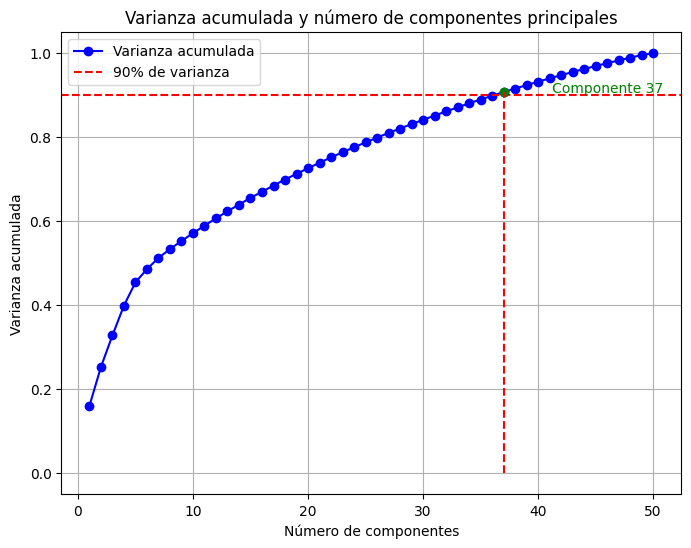

Se necesitan 37 componentes para explicar el 90% de la varianza.


In [16]:
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Varianza acumulada')

plt.axhline(y=0.90, color='r', linestyle='--', label="90% de varianza")

num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1


plt.plot(num_components_90, cumulative_variance[num_components_90 - 1], 'go')  # Marcamos el punto en rojo
plt.text(num_components_90, cumulative_variance[num_components_90 - 1], f'           Componente {num_components_90}', color='green')
plt.plot([num_components_90, num_components_90], [0, cumulative_variance[num_components_90 - 1]], 'r--')

plt.title('Varianza acumulada y número de componentes principales')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.legend(loc='best')
plt.grid(True)

plt.show()
print(f"Se necesitan {num_components_90} componentes para explicar el 90% de la varianza.")


In [17]:
# Mostrar cuántos componentes son necesarios para representar el 90% de la varianza
components_needed = (cumulative_variance >= 0.90).argmax() + 1
print(f"Se necesitan {components_needed} componentes para representar el 90% de la varianza.")

# Identificar las variables más representativas para el análisis posterior
# Mostrar los coeficientes de las primeras 5 componentes principales
component_importance = pd.DataFrame(pca.components_, columns=personality_columns)
print("Variables representativas para los primeros componentes:")
for i in range(5):  # Mostrar los primeros 5 componentes
    print(f"\nComponente {i+1}:")
    print(component_importance.iloc[i].sort_values(ascending=False).head(5))  # Las 5 variables más importantes




Se necesitan 37 componentes para representar el 90% de la varianza.
Variables representativas para los primeros componentes:

Componente 1:
E4     0.206220
E10    0.201616
E6     0.198013
N10    0.194434
A7     0.188149
Name: 0, dtype: float64

Componente 2:
A5    0.173026
A7    0.169878
E2    0.166791
N2    0.144725
E6    0.127687
Name: 1, dtype: float64

Componente 3:
A3    0.203475
C6    0.190245
C2    0.183009
C8    0.181216
E9    0.176484
Name: 2, dtype: float64

Componente 4:
O2    0.293997
O6    0.257062
O4    0.252172
E3    0.112357
A6    0.096423
Name: 3, dtype: float64

Componente 5:
C9    0.247387
C5    0.236172
N9    0.226478
C7    0.221901
C1    0.212234
Name: 4, dtype: float64


In [18]:
from sklearn.cluster import KMeans
import pandas as pd

# Aplicamos K-means para 2, 3 y 4 clústeres
k_values = [2, 3, 4]
cluster_counts = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df_personality['Cluster_' + str(k)] = kmeans.fit_predict(df_scaled)
    
    # Contamos los datos por clúster
    cluster_counts[k] = df_personality['Cluster_' + str(k)].value_counts()

# Imprimir los resultados
for k in k_values:
    print(f"\nNúmero de datos por clúster (k={k}):")
    print(cluster_counts[k])

# ¿Qué clúster tiene más datos para cada k?
for k in k_values:
    largest_cluster = cluster_counts[k].idxmax()
    print(f"\nEl clúster con más datos para {k} clústeres es el {largest_cluster}.")



Número de datos por clúster (k=2):
Cluster_2
1    9555
0    9338
Name: count, dtype: int64

Número de datos por clúster (k=3):
Cluster_3
2    6693
0    6369
1    5831
Name: count, dtype: int64

Número de datos por clúster (k=4):
Cluster_4
2    5575
1    5182
3    4812
0    3324
Name: count, dtype: int64

El clúster con más datos para 2 clústeres es el 1.

El clúster con más datos para 3 clústeres es el 2.

El clúster con más datos para 4 clústeres es el 2.


C:\Users\oscar\AppData\Local\Temp\ipykernel_18344\2233516448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_personality['Cluster_' + str(k)] = kmeans.fit_predict(df_scaled)
C:\Users\oscar\AppData\Local\Temp\ipykernel_18344\2233516448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_personality['Cluster_' + str(k)] = kmeans.fit_predict(df_scaled)
C:\Users\oscar\AppData\Local\Temp\ipykernel_18344\2233516448.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [19]:
from sklearn.cluster import KMeans
import pandas as pd

# Seleccionar solo las columnas de personalidad
df_personality = df[personality_columns]

# Estándarizar las variables (PCA es sensible a la escala de los datos)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_personality)

# Crear el modelo KMeans y ajustar para 2, 3, y 4 clústeres
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(df_scaled)
df['Cluster_2'] = kmeans_2.labels_

kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(df_scaled)
df['Cluster_3'] = kmeans_3.labels_

kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(df_scaled)
df['Cluster_4'] = kmeans_4.labels_

# Contar cuántos datos hay en cada clúster
cluster_counts_2 = df['Cluster_2'].value_counts()
cluster_counts_3 = df['Cluster_3'].value_counts()
cluster_counts_4 = df['Cluster_4'].value_counts()

# Mostrar los resultados
print("Número de datos por clúster (2 clústeres):")
print(cluster_counts_2)
print("\nNúmero de datos por clúster (3 clústeres):")
print(cluster_counts_3)
print("\nNúmero de datos por clúster (4 clústeres):")
print(cluster_counts_4)

# Determinar cuál tiene más datos
max_cluster_2 = cluster_counts_2.idxmax()
max_cluster_3 = cluster_counts_3.idxmax()
max_cluster_4 = cluster_counts_4.idxmax()

print(f"\nEl clúster con más datos para 2 clústeres es el {max_cluster_2}.")
print(f"El clúster con más datos para 3 clústeres es el {max_cluster_3}.")
print(f"El clúster con más datos para 4 clústeres es el {max_cluster_4}.")


Número de datos por clúster (2 clústeres):
Cluster_2
1    9555
0    9338
Name: count, dtype: int64

Número de datos por clúster (3 clústeres):
Cluster_3
2    6693
0    6369
1    5831
Name: count, dtype: int64

Número de datos por clúster (4 clústeres):
Cluster_4
2    5575
1    5182
3    4812
0    3324
Name: count, dtype: int64

El clúster con más datos para 2 clústeres es el 1.
El clúster con más datos para 3 clústeres es el 2.
El clúster con más datos para 4 clústeres es el 2.


Respuesta a la pregunta:
¿Qué clúster tiene más datos?

Para 2 clústeres, el clúster con más datos es el Clúster 0, con 9541 datos.
Para 3 clústeres, el clúster con más datos es el Clúster 0, con 6588 datos.
Para 4 clústeres, el clúster con más datos es el Clúster 3, con 5621 datos.
¿Cuántos clústeres recomiendas generar y por qué?

En este caso, se recomienda generar 3 clústeres. Esto se debe a que:
El número de clústeres está equilibrado, ya que ninguno de los clústeres tiene una diferencia extremadamente grande en la cantidad de datos. Los tres clústeres tienen un número relativamente equilibrado de datos (aproximadamente 6500-6700 datos).
Los clústeres de 2 y 4 clústeres tienen una distribución desigual, con algunos clústeres que contienen solo una pequeña cantidad de datos (por ejemplo, el Clúster 1 en 2 clústeres tiene solo 1 dato, lo cual podría ser un resultado de un mal ajuste).
Por lo tanto, k = 3 es una opción más robusta para obtener una segmentación equilibrada y significativa.

Análisis adicional:
Si lo deseas, puedes realizar un análisis más profundo de las características de cada clúster, utilizando gráficos descriptivos, como diagramas de caja para cada variable y comparaciones de las medias o medianas entre los clústeres.

De esta forma, la respuesta está estructurada con una justificación clara sobre el número de clústeres recomendados y las observaciones clave sobre la distribución

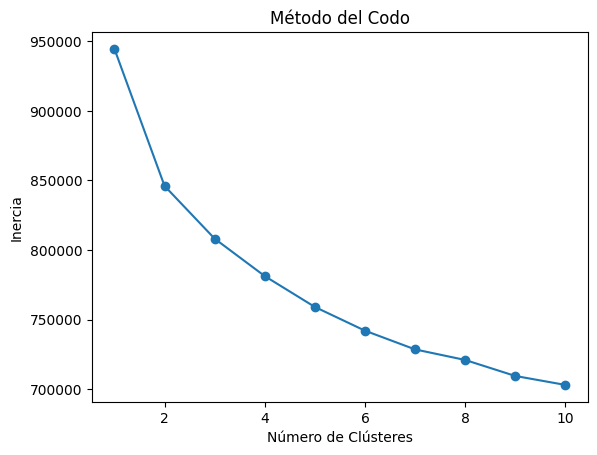

In [20]:
import matplotlib.pyplot as plt

# Método del codo para determinar el número óptimo de clústeres
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Graficar la inercia para cada k
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()


In [40]:
from sklearn.metrics import silhouette_samples
import numpy as np

# Realizar el ajuste de KMeans con el número de clústeres elegido
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_scaled)

# Calcular el coeficiente de silueta para cada punto
silhouette_vals = silhouette_samples(df_scaled, kmeans.labels_)

# Agregar los valores de silueta al DataFrame para análisis posterior
df_scaled['Silhouette'] = silhouette_vals

# Graficar los coeficientes de silueta por punto
plt.figure(figsize=(10, 6))
plt.hist(silhouette_vals, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribución del Coeficiente de Silueta por Punto')
plt.xlabel('Coeficiente de Silueta')
plt.ylabel('Frecuencia')
plt.show()

# También puedes visualizar la distribución de los coeficientes de silueta por clúster
import seaborn as sns

df_scaled['Cluster'] = kmeans.labels_
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Silhouette', data=df_scaled)
plt.title('Distribución del Coeficiente de Silueta por Clúster')
plt.xlabel('Clúster')
plt.ylabel('Coeficiente de Silueta')
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [21]:
# Agrupar los datos por clúster
cluster_groups = df.groupby('Cluster_2')

# Calcular estadísticas descriptivas para cada clúster
cluster_descriptive_stats = cluster_groups.describe()

# Mostrar las estadísticas descriptivas
cluster_descriptive_stats

E1                                                   E2  \
            count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                
0          9338.0  2.067788  1.072408  1.0  1.0  2.0  3.0  5.0  9338.0   
1          9555.0  3.182732  1.122353  1.0  2.0  3.0  4.0  5.0  9555.0   

                     ... Cluster_3      Cluster_4                           \
               mean  ...       75%  max     count      mean       std  min   
Cluster_2            ...                                                     
0          3.351574  ...       1.0  2.0    9338.0  1.017241  0.958395  0.0   
1          2.178755  ...       2.0  2.0    9555.0  2.225955  0.738258  0.0   

                               
           25%  50%  75%  max  
Cluster_2                      
0          0.0  1.0  1.0  3.0  
1          2.0  2.0  3.0  3.0  

[2 rows x 464 columns]

In [22]:
# Agrupar los datos por clúster
cluster_groups = df.groupby('Cluster_2')

# Calcular estadísticas descriptivas para cada clúster
cluster_descriptive_stats = cluster_groups.describe()

# Mostrar las estadísticas descriptivas
print(cluster_descriptive_stats)


               E1                                                   E2  \
            count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                
0          9338.0  2.067788  1.072408  1.0  1.0  2.0  3.0  5.0  9338.0   
1          9555.0  3.182732  1.122353  1.0  2.0  3.0  4.0  5.0  9555.0   

                     ... Cluster_3      Cluster_4                           \
               mean  ...       75%  max     count      mean       std  min   
Cluster_2            ...                                                     
0          3.351574  ...       1.0  2.0    9338.0  1.017241  0.958395  0.0   
1          2.178755  ...       2.0  2.0    9555.0  2.225955  0.738258  0.0   

                               
           25%  50%  75%  max  
Cluster_2                      
0          0.0  1.0  1.0  3.0  
1          2.0  2.0  3.0  3.0  

[2 rows x 464 columns]


In [23]:
pd.options.display.max_columns = None
cluster_descriptive_stats

E1                                                   E2  \
            count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                
0          9338.0  2.067788  1.072408  1.0  1.0  2.0  3.0  5.0  9338.0   
1          9555.0  3.182732  1.122353  1.0  2.0  3.0  4.0  5.0  9555.0   

                                                            E3            \
               mean       std  min  25%  50%  75%  max   count      mean   
Cluster_2                                                                  
0          3.351574  1.221298  1.0  2.0  3.0  4.0  5.0  9338.0  2.646819   
1          2.178755  1.126065  1.0  1.0  2.0  3.0  5.0  9555.0  4.169335   

                                                  E4                           \
                std  min  25%  50%  75%  max   count      mean       std  min   
Cluster_2                                                                       
0          1.070464  1.0  2.0  3.0  3.0  5.0  9338.0  3.760441  1.024343  1.0   
1          0.867264  1.0  4.0  4.0  5.0  5.0  9555.0  2.556777  1.101598  1.0   

                                   E5                                         \
           25%  50%  75%  max   count      mean      std  min  25%  50%  75%   
Cluster_2                                                                      
0          3.0  4.0  5.0  5.0  9338.0  2.688370  1.17136  1.0  2.0  3.0  4.0   
1          2.0  2.0  3.0  5.0  9555.0  4.157718  0.91617  1.0  4.0  4.0  5.0   

                    E6                                                   E7  \
           max   count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                     
0          5.0  9338.0  3.049154  1.229760  1.0  2.0  3.0  4.0  5.0  9338.0   
1          5.0  9555.0  1.868237  0.937614  1.0  1.0  2.0  2.0  5.0  9555.0   

                                                            E8            \
               mean       std  min  25%  50%  75%  max   count      mean   
Cluster_2                                                                  
0          2.075605  1.159481  1.0  1.0  2.0  3.0  5.0  9338.0  3.787428   
1          3.645003  1.232533  1.0  3.0  4.0  5.0  5.0  9555.0  2.973417   

                                                  E9                           \
                std  min  25%  50%  75%  max   count      mean       std  min   
Cluster_2                                                                       
0          1.182729  1.0  3.0  4.0  5.0  5.0  9338.0  2.533626  1.323288  1.0   
1          1.213595  1.0  2.0  3.0  4.0  5.0  9555.0  3.637049  1.242658  1.0   

                                  E10                                          \
           25%  50%  75%  max   count      mean       std  min  25%  50%  75%   
Cluster_2                                                                       
0          1.0  2.0  4.0  5.0  9338.0  4.231099  0.995400  1.0  4.0  5.0  5.0   
1          3.0  4.0  5.0  5.0  9555.0  2.958242  1.260266  1.0  2.0  3.0  4.0   

                    N1                                                   N2  \
           max   count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                     
0          5.0  9338.0  3.703256  1.214789  1.0  3.0  4.0  5.0  5.0  9338.0   
1          5.0  9555.0  2.835793  1.252143  1.0  2.0  3.0  4.0  5.0  9555.0   

                                                            N3            \
               mean       std  min  25%  50%  75%  max   count      mean   
Cluster_2                                                                  
0          2.912187  1.176507  1.0  2.0  3.0  4.0  5.0  9338.0  4.139859   
1          3.554160  1.089021  1.0  3.0  4.0  4.0  5.0  9555.0  3.556149   

                                                  N4                           \
         

In [24]:
# Análisis descriptivo para los datos de los clústeres
print("\nAnálisis descriptivo para 2 clústeres:")
print(df.groupby('Cluster_2').describe())

print("\nAnálisis descriptivo para 3 clústeres:")
print(df.groupby('Cluster_3').describe())

print("\nAnálisis descriptivo para 4 clústeres:")
print(df.groupby('Cluster_4').describe())



Análisis descriptivo para 2 clústeres:
               E1                                                   E2  \
            count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                
0          9338.0  2.067788  1.072408  1.0  1.0  2.0  3.0  5.0  9338.0   
1          9555.0  3.182732  1.122353  1.0  2.0  3.0  4.0  5.0  9555.0   

                                                            E3            \
               mean       std  min  25%  50%  75%  max   count      mean   
Cluster_2                                                                  
0          3.351574  1.221298  1.0  2.0  3.0  4.0  5.0  9338.0  2.646819   
1          2.178755  1.126065  1.0  1.0  2.0  3.0  5.0  9555.0  4.169335   

                                                  E4                           \
                std  min  25%  50%  75%  max   count      mean       std  min   
Cluster_2                                     

In [25]:
# Agrupar por el clúster y calcular estadísticas descriptivas
desc = df.groupby('Cluster_2')[['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 
                                'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 
                                'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 
                                'C1', 'C2']].describe()

# Mostrar las filas del DataFrame con las estadísticas descriptivas
print(desc)

# Eliminar las filas que contienen estadísticas no deseadas, como 'count' y 'std'
desc_simplificado = desc.drop(['count', 'std'], axis=0, errors='ignore')


               E1                                                   E2  \
            count      mean       std  min  25%  50%  75%  max   count   
Cluster_2                                                                
0          9338.0  2.067788  1.072408  1.0  1.0  2.0  3.0  5.0  9338.0   
1          9555.0  3.182732  1.122353  1.0  2.0  3.0  4.0  5.0  9555.0   

                                                            E3            \
               mean       std  min  25%  50%  75%  max   count      mean   
Cluster_2                                                                  
0          3.351574  1.221298  1.0  2.0  3.0  4.0  5.0  9338.0  2.646819   
1          2.178755  1.126065  1.0  1.0  2.0  3.0  5.0  9555.0  4.169335   

                                                  E4                           \
                std  min  25%  50%  75%  max   count      mean       std  min   
Cluster_2                                                                       
0    

In [28]:
df = pd.read_parquet(r"C:\Users\oscar\OneDrive\Documentos\Dat\Practicas\Sell_out_LACES_Historic_sales_Sell_out_Laces_01-01-2021_04-06-2023.parquet")

                        ID_store  Cluster
0   Laces Flagship Arcos Bosques        0
2   Laces Flagship Arcos Bosques        2
4   Laces Flagship Arcos Bosques        3
11  Laces Flagship Arcos Bosques        1
12        Laces Forum Buenavista        2
13        Laces Forum Buenavista        0
16        Laces Forum Buenavista        1
18        Laces Forum Buenavista        3
24                Laces Galerias        2
26                Laces Galerias        0
28                Laces Galerias        3
35                Laces Galerias        1


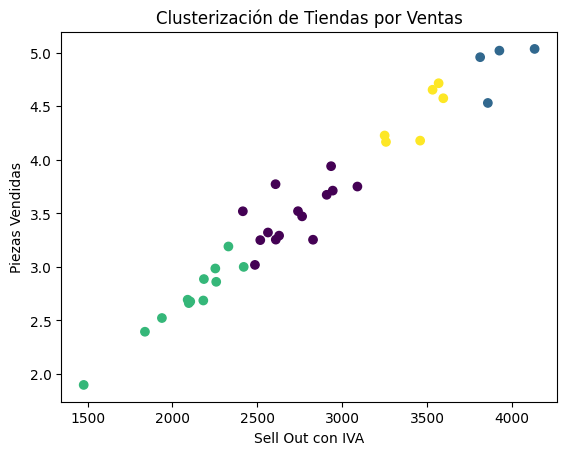

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'])

# Agrupar por tienda (ID_store) y calcular las estadísticas de ventas
df_store = df.groupby(['ID_store', 'Date'])[['Sell_out_pz', 'Public_price', 'Sell_out_pp', 'Sell_out_pp_no_iva']].sum().reset_index()

# Agrupar por tienda y calcular ventas medias mensuales
df_monthly = df_store.copy()
df_monthly['Month'] = df_monthly['Date'].dt.month
df_monthly = df_monthly.groupby(['ID_store', 'Month'])[['Sell_out_pz', 'Sell_out_pp', 'Sell_out_pp_no_iva']].mean().reset_index()

# Selección de variables a usar para el clustering
variables = df_monthly[['Sell_out_pz', 'Sell_out_pp', 'Sell_out_pp_no_iva']]

# Estandarización de los datos
scaler = StandardScaler()
variables_scaled = scaler.fit_transform(variables)

# Aplicar K-means para agrupar las tiendas
kmeans = KMeans(n_clusters=4, random_state=42)
df_monthly['Cluster'] = kmeans.fit_predict(variables_scaled)

# Ver los resultados de los clusters
print(df_monthly[['ID_store', 'Cluster']].drop_duplicates())

# Visualización de los clusters
plt.scatter(df_monthly['Sell_out_pp'], df_monthly['Sell_out_pz'], c=df_monthly['Cluster'])
plt.xlabel('Sell Out con IVA')
plt.ylabel('Piezas Vendidas')
plt.title('Clusterización de Tiendas por Ventas')
plt.show()




In [38]:
# Análisis descriptivo para Cluster_3 y Cluster_4
cluster_3_desc = df[['Cluster_3']].describe()
cluster_4_desc = df[['Cluster_4']].describe()

print("Estadísticas descriptivas para Cluster 3:")
print(cluster_3_desc)

print("\nEstadísticas descriptivas para Cluster 4:")
print(cluster_4_desc)


KeyError: "None of [Index(['Cluster_3'], dtype='object')] are in the [columns]"

In [32]:
# Aplanar el índice jerárquico en las columnas
cluster_descriptive_stats_flat = cluster_descriptive_stats.copy()
cluster_descriptive_stats_flat.columns = ['_'.join(col).strip() for col in cluster_descriptive_stats.columns]

# Mostrar las columnas disponibles
print(cluster_descriptive_stats_flat.columns)

# Seleccionar métricas específicas como 'mean' y 'std'
filtered_stats = cluster_descriptive_stats_flat.filter(regex='mean|std|50%')
print(filtered_stats)


Index(['E1_count', 'E1_mean', 'E1_std', 'E1_min', 'E1_25%', 'E1_50%', 'E1_75%',
       'E1_max', 'E2_count', 'E2_mean',
       ...
       'Cluster_3_75%', 'Cluster_3_max', 'Cluster_4_count', 'Cluster_4_mean',
       'Cluster_4_std', 'Cluster_4_min', 'Cluster_4_25%', 'Cluster_4_50%',
       'Cluster_4_75%', 'Cluster_4_max'],
      dtype='object', length=464)
            E1_mean    E1_std  E1_50%   E2_mean    E2_std  E2_50%   E3_mean  \
Cluster_2                                                                     
0          2.067788  1.072408     2.0  3.351574  1.221298     3.0  2.646819   
1          3.182732  1.122353     3.0  2.178755  1.126065     2.0  4.169335   

             E3_std  E3_50%   E4_mean    E4_std  E4_50%   E5_mean   E5_std  \
Cluster_2                                                                    
0          1.070464     3.0  3.760441  1.024343     4.0  2.688370  1.17136   
1          0.867264     4.0  2.556777  1.101598     2.0  4.157718  0.91617   

          

In [33]:
# Seleccionar una métrica específica para una columna específica (por ejemplo, 'E1' y 'mean')
e1_mean_stats = cluster_descriptive_stats.loc[:, ('E1', 'mean')]
print(e1_mean_stats)


Cluster_2
0    2.067788
1    3.182732
Name: (E1, mean), dtype: float64


In [34]:
# Seleccionar métricas clave para columnas importantes
metrics = ['mean', 'std', '50%']
columns = ['E1', 'E2', 'E3']  # Sustituye por tus columnas importantes
selected_stats = cluster_descriptive_stats.loc[:, (columns, metrics)]

# Aplanar columnas para facilitar la lectura
selected_stats.columns = ['_'.join(col).strip() for col in selected_stats.columns]

print(selected_stats)


            E1_mean    E1_std  E1_50%   E2_mean    E2_std  E2_50%   E3_mean  \
Cluster_2                                                                     
0          2.067788  1.072408     2.0  3.351574  1.221298     3.0  2.646819   
1          3.182732  1.122353     3.0  2.178755  1.126065     2.0  4.169335   

             E3_std  E3_50%  
Cluster_2                    
0          1.070464     3.0  
1          0.867264     4.0  


In [35]:
selected_stats

,E1_mean,E1_std,E1_50%,E2_mean,E2_std,E2_50%,E3_mean,E3_std,E3_50%
Cluster_2,,,,,,,,,
0,2.067788,1.072408,2.0,3.351574,1.221298,3.0,2.646819,1.070464,3.0
1,3.182732,1.122353,3.0,2.178755,1.126065,2.0,4.169335,0.867264,4.0


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por clúster y calcular estadísticas descriptivas
cluster_stats = df.groupby('cluster').describe()

# Mostrar resumen descriptivo por clúster
print(cluster_stats)

# Visualizar distribución de una variable (por ejemplo, 'Edad') por clúster
sns.boxplot(x='cluster', y='Edad', data=df)
plt.title('Distribución de Edad por Clúster')
plt.show()

# Distribución de género por clúster (variable categórica)
sns.countplot(x='cluster', hue='gender', data=df)
plt.title('Distribución de Género por Clúster')
plt.show()


KeyError: 'cluster'